## Setup and Data Loading

We'll work with one session (sub-01, ses-010) containing 4 runs of Super Mario Bros gameplay.

**Key constants:**
- Subject: sub-01
- Session: ses-010
- TR: 1.49 seconds
- ~40 minutes of gameplay total
- ~3800+ behavioral events

In [ ]:
# @title Environment Setup (Colab & Local)
# @markdown This cell detects your environment and sets up the necessary dependencies and paths.
# @markdown On Colab, it will mount Google Drive to persist datasets and avoid re-downloading.

import sys
import os
import subprocess
from pathlib import Path

# Detect Colab
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("🚀 Detected Google Colab Environment")
    print("-----------------------------------------")

    # 1. Mount Google Drive
    try:
        from google.colab import drive
        print("📂 Mounting Google Drive...")
        drive.mount('/content/drive')
    except ImportError:
        print("⚠️ Google Drive not available. Using local runtime storage (will be lost on disconnect).")

    # Define project path
    # If Drive is available, use it. Otherwise use /content
    if os.path.exists('/content/drive/MyDrive'):
        DRIVE_ROOT = Path("/content/drive/MyDrive")
        PROJECT_NAME = "mario_tutorials"
        PROJECT_PATH = DRIVE_ROOT / PROJECT_NAME
    else:
        PROJECT_PATH = Path("/content/mario_tutorials")

    # 2. Setup Project Directory
    if not PROJECT_PATH.exists():
        print(f"🆕 Creating project directory at {PROJECT_PATH}...")
        PROJECT_PATH.mkdir(parents=True, exist_ok=True)
        
        print("⏬ Cloning repository...")
        try:
            subprocess.run(["git", "clone", "https://github.com/courtois-neuromod/mario.tutorials.git", str(PROJECT_PATH)], check=True)
        except subprocess.CalledProcessError:
            # Fallback if directory is not empty or git fails
            print("⚠️ Clone failed (maybe directory exists?). Attempting to pull...")
            os.chdir(PROJECT_PATH)
            subprocess.run(["git", "pull"], check=False)
    else:
        print(f"✅ Found existing project at {PROJECT_PATH}")

    # Change working directory
    os.chdir(PROJECT_PATH)
    print(f"📍 Working directory: {os.getcwd()}")

    # 3. Install System Dependencies (git-annex for DataLad)
    print("📦 Installing system dependencies (git-annex)...")
    subprocess.run(["apt-get", "install", "-y", "git-annex"], check=True)

    # 4. Install Python Dependencies
    print("🐍 Installing Python packages from requirements.txt...")
    if os.path.exists("requirements.txt"):
         # Using pip install -r is more robust
         subprocess.run([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"], check=True)
    else:
         print("⚠️ requirements.txt not found! Installing default packages...")
         subprocess.run([sys.executable, "-m", "pip", "install", "datalad", "nilearn", "gym-retro", "ipympl", "pandas", "scipy", "matplotlib", "seaborn", "h5py", "invoke"], check=True)
    
    # 5. Add src to path
    if str(PROJECT_PATH / "src") not in sys.path:
        sys.path.append(str(PROJECT_PATH / "src"))
    
    print("✅ Environment setup complete!")

else:
    print("🖥️ Running Locally")
    # Ensure src is in path
    if str(Path.cwd() / "src") not in sys.path:
        sys.path.append(str(Path.cwd() / "src"))
    print("✅ Local environment assumed ready.")


In [ ]:
# Silent Setup
try:
    from setup_utils import setup_all
    # Ensure data is available (silently checks)
    setup_all(subject="sub-01", session="ses-010")
except ImportError:
    print("Setup utils not found. Please ensure src is in path.")
except Exception as e:
    print(f"Setup warning: {e}")


In [1]:
# Setup - hidden from presentation
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import plotting
import warnings
warnings.filterwarnings('ignore')

# Add src to path
src_dir = Path('..') / 'src'
sys.path.insert(0, str(src_dir))

from utils import (
    get_sourcedata_path,
    get_derivatives_path,
    load_events,
    get_session_runs,
    load_lowlevel_confounds
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Define constants
SUBJECT = 'sub-01'
SESSION = 'ses-010'
TR = 1.49

print("Setup complete!")

# Get sourcedata path
sourcedata_path = get_sourcedata_path()

# Load runs and events
runs = get_session_runs(SUBJECT, SESSION, get_sourcedata_path())
print(f"Found {len(runs)} runs: {runs}\n")

# Load all events
all_events = []
for run in runs:
    events = load_events(SUBJECT, SESSION, run, get_sourcedata_path())
    all_events.append(events)
    print(f"  {run}: {len(events)} events")

EVENTS_LOADED = True


Setup complete!
Found 4 runs: ['run-1', 'run-2', 'run-3', 'run-4']

  run-1: 953 events
  run-2: 986 events
  run-3: 892 events
  run-4: 1033 events


# GLM Analysis

## Finding Brain Regions for Actions and Events

## GLM Fundamentals

### The General Linear Model for fMRI

**Basic idea:** Model brain activity as a weighted sum of explanatory variables

```
BOLD(t) = β₁·Regressor₁(t) + β₂·Regressor₂(t) + ... + ε(t)
```

**Steps:**
1. **Event timing** → Neural activity (stick functions)
2. **Add confounds** → Motion, physiology, low-level features
3. **HRF convolution** → Expected BOLD response
4. **Fit model** → Estimate β weights (using nilearn's FirstLevelModel)
5. **Compute contrasts** → Test hypotheses

**Our confound strategy (following shinobi_fmri):**
- **Motion:** 6 motion parameters from fMRIPrep
- **Physiology:** WM, CSF signals (loaded via load_confounds)
- **Task:** Button press counts (manual psychophysics confound)
- **Standardization:** Done by nilearn (`clean_img` with `standardize=True`)

**Models we'll fit:**
1. **Hand lateralization:** LEFT_THUMB (D-pad) vs RIGHT_THUMB (A+B buttons)

**Multi-run fitting:**
- nilearn's FirstLevelModel can fit all runs simultaneously
- Provides list of BOLD images + list of design matrices
- More efficient than fitting runs separately

In [2]:
# Step 1: Load BOLD image
from utils import load_bold
from nilearn.image import clean_img

bold_img = load_bold(SUBJECT, SESSION, runs[0], sourcedata_path)
bold_clean = clean_img(
    bold_img,
    standardize=True,
    detrend=True,
    high_pass=None,
    t_r=TR
)

## 1. Loading fMRIPrep Confounds

**What are confounds?**
Signals that affect BOLD but aren't related to our task.

**fMRIPrep provides:**
- **Motion (24 params):** 6 motion parameters + derivatives + quadratic terms
  - Translation: X, Y, Z displacement
  - Rotation: Roll, pitch, yaw
- **Physiology (2 params):** White matter + CSF signals
  - Captures non-neural noise from tissues
- **Drift removal (9 params):** Cosine basis functions for high-pass filtering
  - Removes slow scanner drift

**Strategy:** `load_confounds` from nilearn automatically finds and loads the correct confounds file for each run.

In [3]:
# Step 2: Load fMRIPrep confounds

from nilearn.interfaces.fmriprep import load_confounds

def load_fmriprep_confounds(subject, session, run):
    """
    Load confounds from fMRIPrep for a given run.
    
    Parameters
    ----------
    subject : str
        Subject ID (e.g., 'sub-01')
    session : str
        Session ID (e.g., 'ses-010')
    run : str
        Run ID (e.g., 'run-1')
    derivatives_path : Path
        Path to derivatives directory
        
    Returns
    -------
    confounds_df : pd.DataFrame
        Confounds dataframe with selected regressors
    sample_mask : np.ndarray or None
        Sample mask (if applicable)
    """
    sourcedata_path = get_sourcedata_path()
    # Path to preprocessed BOLD image
    bold_path = (
        sourcedata_path / 'mario.fmriprep' / subject / session / 'func' /
        f'{subject}_{session}_task-mario_{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    )
    
    # Load confounds using nilearn's fMRIPrep interface
    # This automatically finds the corresponding *_desc-confounds_timeseries.tsv file
    confounds_df, sample_mask = load_confounds(
        str(bold_path),
        strategy=("motion", "high_pass", "wm_csf"),
        motion="full",       # Motion parameters (6 params + derivatives + powers)
        wm_csf="basic",      # White matter + CSF signals
        global_signal="full", # Global signal
        demean=False, # Because we will standardize later
    )

    return confounds_df, sample_mask

# Test on first run
confounds_df, sample_mask = load_fmriprep_confounds(
    SUBJECT, SESSION, runs[0]
)

print(f"✓ Loaded {confounds_df.shape[1]} confounds for {runs[0]}")
print(f"  Timepoints: {confounds_df.shape[0]}")
print(f"\nConfound types:")
motion_cols = [c for c in confounds_df.columns if 'trans' in c or 'rot' in c]
physio_cols = [c for c in confounds_df.columns if 'csf' in c or 'white_matter' in c or 'global_signal' in c]
drift_cols = [c for c in confounds_df.columns if 'cosine' in c]
print(f"  Motion: {len(motion_cols)} (6 params + derivatives + quadratic)")
print(f"  Physiology: {len(physio_cols)} (WM, CSF, global signal)")
print(f"  Drift: {len(drift_cols)} (cosine basis for high-pass filtering)")

✓ Loaded 35 confounds for run-1
  Timepoints: 444

Confound types:
  Motion: 24 (6 params + derivatives + quadratic)
  Physiology: 2 (WM, CSF, global signal)
  Drift: 9 (cosine basis for high-pass filtering)


## 2. Adding Psychophysics Confounds

**Low-level visual/game features** we want to control for:

- **Luminance:** Average screen brightness (60 Hz)
- **Optical flow:** Visual motion magnitude (60 Hz)
- **Audio envelope:** Sound intensity (60 Hz)

**Why add these?**
- Game visual features activate visual cortex but aren't our focus
- Controlling for them isolates higher-level cognitive signals
- Follows the shinobi_fmri confound strategy

**Processing:** Downsample from 60 Hz to TR resolution (~1.49s) by averaging within each TR.

In [4]:
# Step 3: Add psychophysics confounds (following shinobi_fmri)

def add_psychophysics_confounds(confounds_df, lowlevel_features, tr):
    """
    Add psychophysics (low-level game features) as confounds.
    
    Following shinobi_fmri: downsample 60Hz features to TR.
    These capture low-level visual/game state that we want to regress out.
    
    Parameters
    ----------
    confounds_df : pd.DataFrame
        Existing confounds
    lowlevel_features : dict
        Dictionary of feature name -> 60Hz signal arrays
    tr : float
        Repetition time in seconds
        
    Returns
    -------
    pd.DataFrame
        Confounds with added psychophysics columns
    """
    if lowlevel_features is None or len(lowlevel_features) == 0:
        return confounds_df
    
    confounds_df = confounds_df.copy()
    n_scans = len(confounds_df)
    
    # Downsample each feature from 60Hz to TR
    for feature_name, signal_60hz in lowlevel_features.items():
        # Convert 60Hz signal to TR-sampled
        n_frames = len(signal_60hz)
        frame_times = np.arange(n_frames) / 60.0  # 60 fps
        
        # Bin frames by TR
        tr_bins = (frame_times // tr).astype(int)
        
        # Average within each TR
        signal_tr = np.zeros(n_scans)
        for tr_idx in range(n_scans):
            frames_in_tr = signal_60hz[tr_bins == tr_idx]
            if len(frames_in_tr) > 0:
                signal_tr[tr_idx] = np.mean(frames_in_tr)
        
        # Add to confounds
        confounds_df[f'{feature_name}'] = signal_tr
    
    return confounds_df

lowlevel_features = load_lowlevel_confounds(SUBJECT, SESSION, runs[0], sourcedata_path)

confounds_df = add_psychophysics_confounds(confounds_df, lowlevel_features, TR)
print(f"✓ Added {len(lowlevel_features.keys())} psychophysics confounds:")
for key in lowlevel_features.keys():
    print(f"  - {key}")

print(f"\n📊 Total confounds: {confounds_df.shape[1]}")

✓ Added 3 psychophysics confounds:
  - luminance
  - optical_flow
  - audio_envelope

📊 Total confounds: 38


## 3. Adding Button Press Confounds

**Motor artifact from button pressing:**

For each TR, count total button presses (A, B, LEFT, RIGHT, UP, DOWN).

**Why control for this?**
- Button presses create motor-related BOLD signal
- We want to isolate *which hand* is active, not *how many* presses
- Removes variance from button press frequency

**Example:** If a TR has 7 button presses, `button_count_press = 7`.

In [5]:
# Step 4: Add button press confounds (following shinobi_fmri)

def add_button_press_confounds(confounds_df, events_df, tr):
    """
    Add button press counts as confounds.
    
    Following shinobi_fmri: count button presses in each TR.
    This captures motor-related noise from button pressing.
    
    Parameters
    ----------
    confounds_df : pd.DataFrame
        Existing confounds
    events_df : pd.DataFrame
        Events dataframe with trial_type, onset columns
    tr : float
        Repetition time in seconds
        
    Returns
    -------
    pd.DataFrame
        Confounds with added button_count_press column
    """
    confounds_df = confounds_df.copy()
    n_scans = len(confounds_df)
    
    # Initialize button press count
    button_count = np.zeros(n_scans)
    
    # Button types
    button_types = ['A', 'B', 'LEFT', 'RIGHT', 'UP', 'DOWN']
    
    # Count presses in each TR
    for _, event in events_df.iterrows():
        if event['trial_type'] in button_types:
            tr_idx = int(np.floor(event['onset'] / tr))
            if 0 <= tr_idx < n_scans:
                button_count[tr_idx] += 1
    
    confounds_df['button_count_press'] = button_count
    
    return confounds_df

# Test on first run
events = load_events(SUBJECT, SESSION, runs[0], sourcedata_path)
confounds_df = add_button_press_confounds(confounds_df, events, TR)

button_count = confounds_df['button_count_press'].values
print(f"✓ Added button_count_press confound")
print(f"  Mean: {button_count.mean():.2f} presses/TR")
print(f"  Max: {int(button_count.max())} presses in a single TR")
print(f"  Non-zero TRs: {(button_count > 0).sum()}/{len(button_count)}")
print(f"\n📊 Total confounds: {confounds_df.shape[1]}")

✓ Added button_count_press confound
  Mean: 1.90 presses/TR
  Max: 7 presses in a single TR
  Non-zero TRs: 303/444

📊 Total confounds: 39


## 4. Standardizing Confounds

**Why standardize (z-score) confounds?**

```python
scaler = StandardScaler()  # mean=0, std=1
confounds_df = scaler.fit_transform(confounds_df)
```

- Different confounds have different scales:
  - Motion: millimeters
  - Luminance: arbitrary units
  - Button count: integer counts
- Standardization ensures they contribute equally to the GLM
- Prevents high-variance confounds from dominating

In [6]:
# Step 5: Standardize confounds
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
confounds_df.loc[:, confounds_df.columns] = scaler.fit_transform(confounds_df)
print(f"✓ Standardized confounds")


✓ Standardized confounds


## 5. Visualizing the Confound Structure

Before proceeding to the GLM, let's visualize our confounds to verify they look reasonable.

**What to look for:**
- Motion spikes (should be small for good data)
- Button press patterns (should match gameplay)
- Drift removal (cosine basis smoothness)
- Psychophysics features (should track game events)

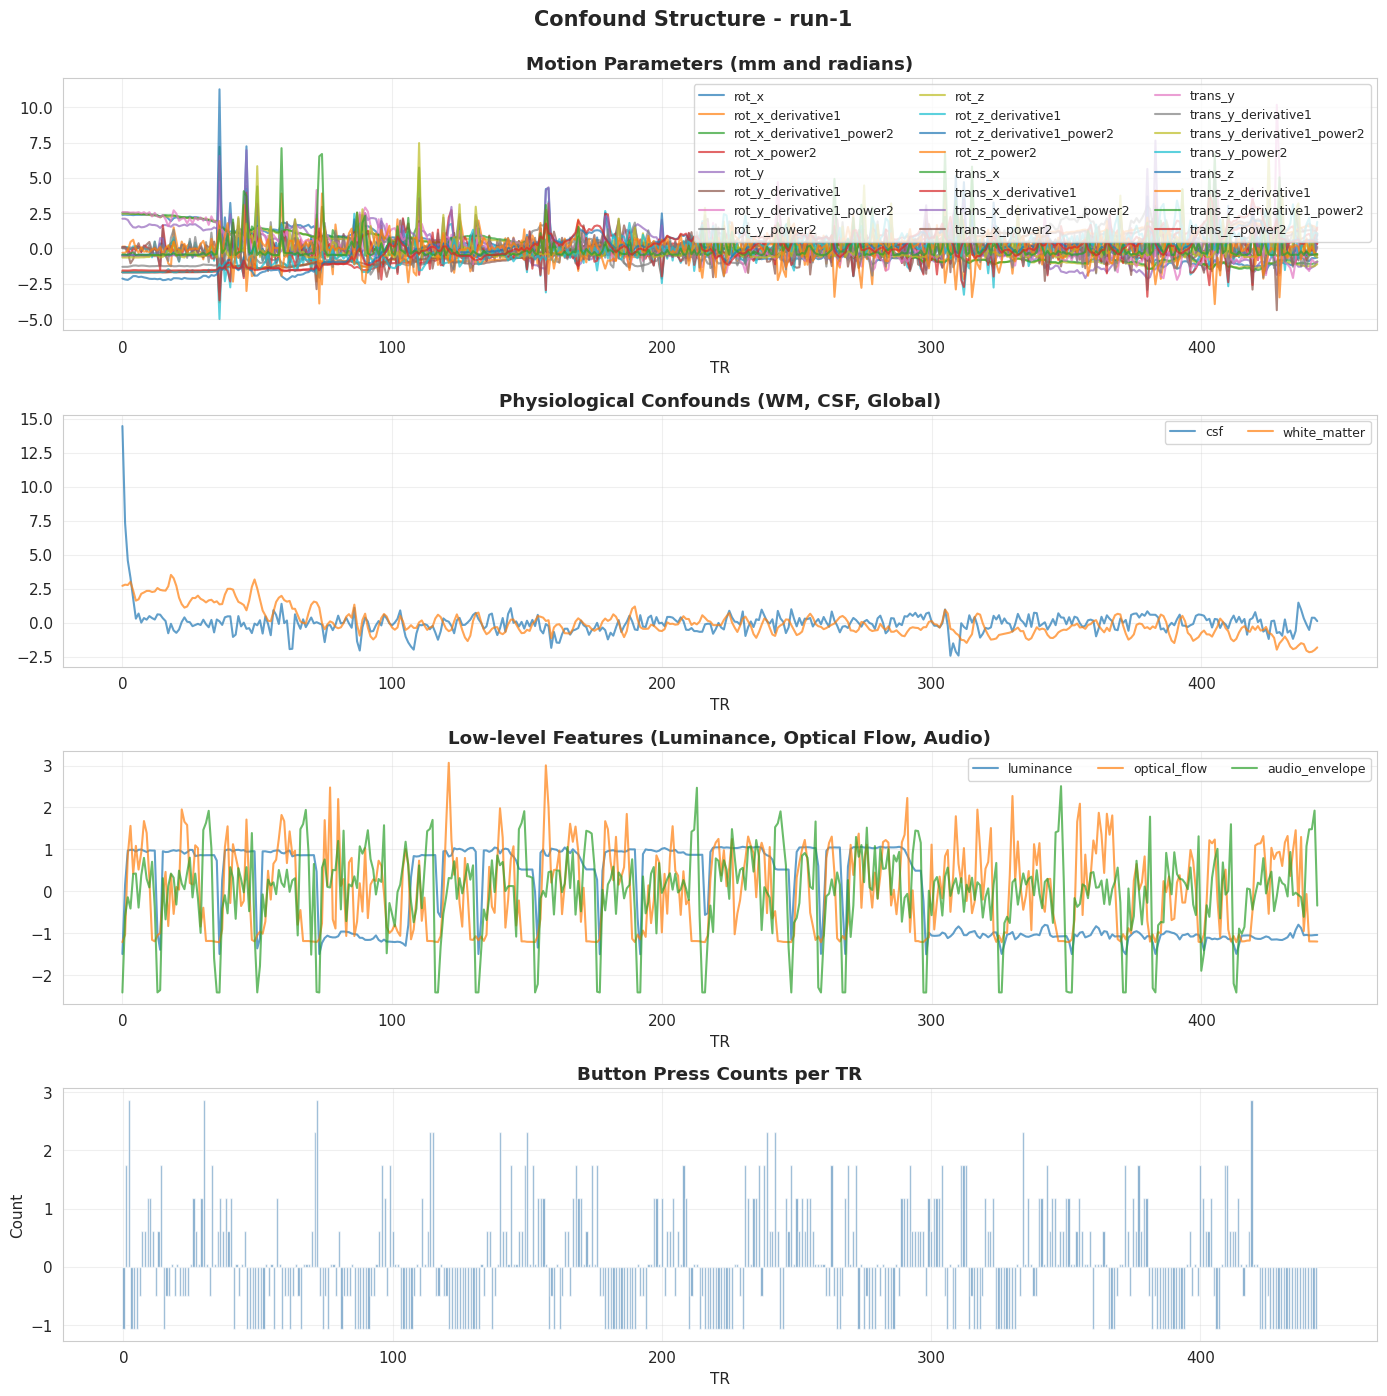

In [7]:
# Visualize confound structure
from glm_utils import plot_confounds_structure

fig = plot_confounds_structure(confounds_df, runs[0], button_count=button_count)
plt.show()

## 6. Creating Hand Lateralization Events

**Hypothesis:** Contralateral motor control

**Hand mapping on SNES controller:**
- **LEFT_THUMB:** D-pad buttons (LEFT, RIGHT, UP, DOWN) → controlled by left thumb
- **RIGHT_THUMB:** Action buttons (A, B) → controlled by right thumb

**Expected brain activation:**
- LEFT_THUMB → Right motor cortex (contralateral control)
- RIGHT_THUMB → Left motor cortex (contralateral control)

**Implementation:** Convert raw button events to two conditions (LEFT_THUMB, RIGHT_THUMB) with onset and duration.

In [8]:
# Step 6: Create hand lateralization events

def create_hand_lateralization_events(events_df):
    """
    Create hand lateralization events from button presses.
    
    LEFT_THUMB: D-pad buttons (LEFT, RIGHT, UP, DOWN) - controlled by left thumb
    RIGHT_THUMB: Action buttons (A, B) - controlled by right thumb
    
    Parameters
    ----------
    events_df : pd.DataFrame
        Events with trial_type, onset, duration
        
    Returns
    -------
    pd.DataFrame
        Events with LEFT_THUMB and RIGHT_THUMB conditions
    """
    hand_events = []
    
    for _, event in events_df.iterrows():
        trial_type = event['trial_type']
        
        if trial_type in ['LEFT', 'RIGHT', 'UP', 'DOWN']:
            hand_events.append({
                'onset': event['onset'],
                'duration': event['duration'],
                'trial_type': 'LEFT_THUMB'
            })
        elif trial_type in ['A', 'B']:
            hand_events.append({
                'onset': event['onset'],
                'duration': event['duration'],
                'trial_type': 'RIGHT_THUMB'
            })
    
    return pd.DataFrame(hand_events)

# Create for first run
hand_events = create_hand_lateralization_events(events)

# Show summary
n_left = (hand_events['trial_type'] == 'LEFT_THUMB').sum()
n_right = (hand_events['trial_type'] == 'RIGHT_THUMB').sum()

print(f"Hand lateralization events for {runs[0]}:")
print(f"  LEFT_THUMB: {n_left} events")
print(f"  RIGHT_THUMB: {n_right} events")
print(f"\nFirst few events:")
print(hand_events.head(10))

Hand lateralization events for run-1:
  LEFT_THUMB: 446 events
  RIGHT_THUMB: 398 events

First few events:
      onset  duration   trial_type
0  1.967257     0.533  RIGHT_THUMB
1  1.967257     0.067  RIGHT_THUMB
2  2.217257     0.733   LEFT_THUMB
3  2.667257     0.350  RIGHT_THUMB
4  2.850257     0.317  RIGHT_THUMB
5  3.234257     0.616  RIGHT_THUMB
6  3.334257     0.216   LEFT_THUMB
7  3.517257     0.317  RIGHT_THUMB
8  3.550257     0.167   LEFT_THUMB
9  3.567257     0.750   LEFT_THUMB


## 7. Building the GLM Design Matrix

**The design matrix** contains all regressors (columns) for each timepoint (rows).

**Structure:**
1. **Task regressors (2):** LEFT_THUMB, RIGHT_THUMB
   - Events convolved with hemodynamic response function (HRF)
   - SPM canonical HRF: models 6-second BOLD rise and fall
2. **Confounds (~39):** Motion, physiology, drift, psychophysics, button counts
3. **Constant (1):** Baseline/intercept

**HRF convolution:** Button press at t=0 → BOLD peaks at t=6s → returns to baseline by t=20s

✓ Created design matrix for run-1

Design matrix structure:
  Shape: (444, 42)
  Timepoints: 444
  Regressors: 42

Regressor breakdown:
  Task: 2 (LEFT_THUMB, RIGHT_THUMB)
  Confounds: 39
  Constant: 1


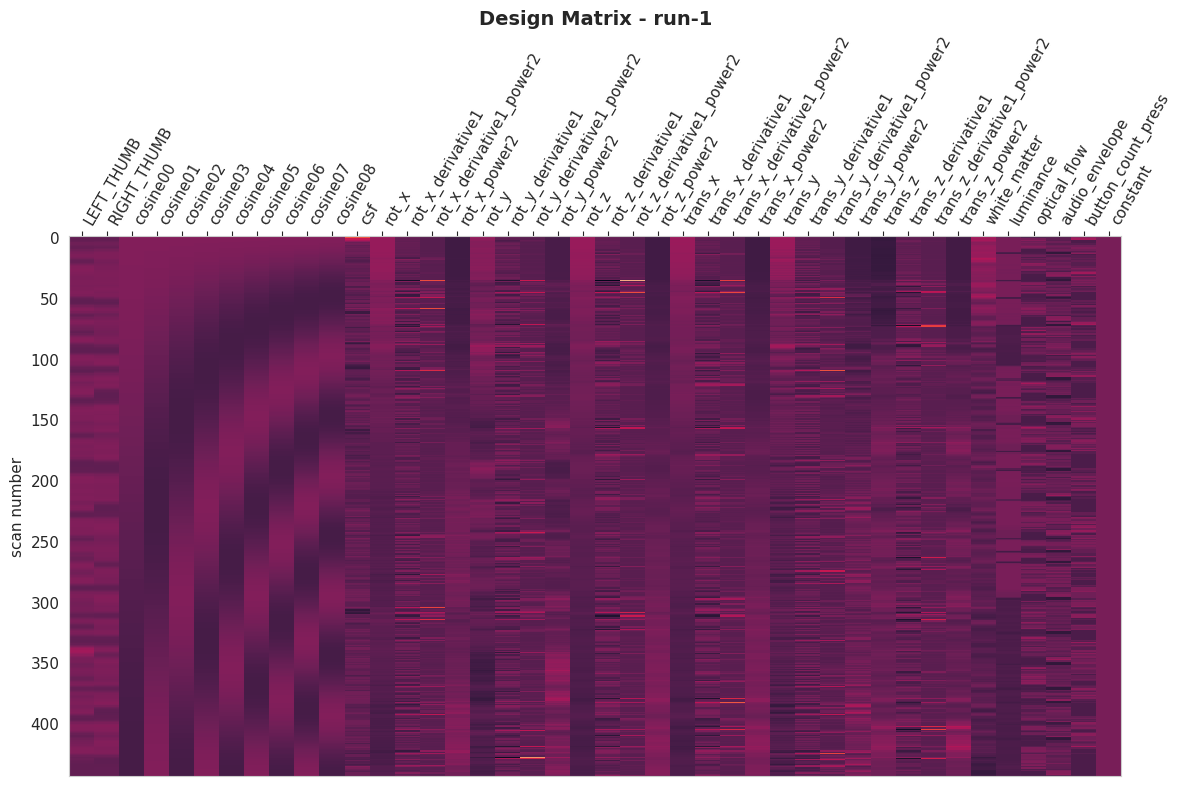

In [9]:
# Step 7: Create design matrix for one run

from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

def create_design_matrix(bold_img, hand_events, confounds_df, tr):
    """
    Create design matrix for GLM analysis.
    
    Parameters
    ----------
    bold_img : Nifti1Image
        Preprocessed BOLD image
    hand_events : pd.DataFrame
        Hand lateralization events (LEFT_THUMB, RIGHT_THUMB)
    confounds_df : pd.DataFrame
        Confounds (motion, physiology, task)
    tr : float
        Repetition time in seconds
        
    Returns
    -------
    design_matrix : pd.DataFrame
        Design matrix with task regressors + confounds + drift
    """
    # Get frame times
    n_scans = bold_img.shape[-1]
    frame_times = np.arange(n_scans) * tr
    
    # Create design matrix
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events=hand_events,
        hrf_model='spm',           # SPM canonical HRF
        drift_model=None,          # Handled by confounds
        high_pass=None,            # Handled by confounds
        add_regs=confounds_df,
        add_reg_names=list(confounds_df.columns)
    )
    
    return design_matrix

# Create design matrix for first run
design_matrix = create_design_matrix(
    bold_img, hand_events, confounds_df, TR
)

print(f"✓ Created design matrix for {runs[0]}\n")
print(f"Design matrix structure:")
print(f"  Shape: {design_matrix.shape}")
print(f"  Timepoints: {design_matrix.shape[0]}")
print(f"  Regressors: {design_matrix.shape[1]}")
print(f"\nRegressor breakdown:")
print(f"  Task: 2 (LEFT_THUMB, RIGHT_THUMB)")
print(f"  Confounds: {len(confounds_df.columns)}")
print(f"  Constant: 1")

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
plot_design_matrix(design_matrix, ax=ax, rescale=True);
ax.set_title(f'Design Matrix - {runs[0]}', fontsize=14, fontweight='bold')
ax.grid(False)  # Deactivate grid
plt.tight_layout()

## 8. Scrubbing Invalid Timepoints

**Problem:** Not all TRs have valid behavioral data

Some game repetitions are missing replay files (.bk2), meaning we don't have frame-by-frame gameplay data.

**Solution:** Add scrub regressors

For each TR without valid replay data, add a one-hot regressor:
```
scrub1 = [0, 0, 1, 0, 0, ...]  # Removes TR #2
scrub2 = [0, 0, 0, 1, 0, ...]  # Removes TR #3
```

This **regresses out** invalid timepoints, ensuring we only analyze TRs with corresponding behavioral data.

✓ Added scrub regressors

📊 Total regressors: 89


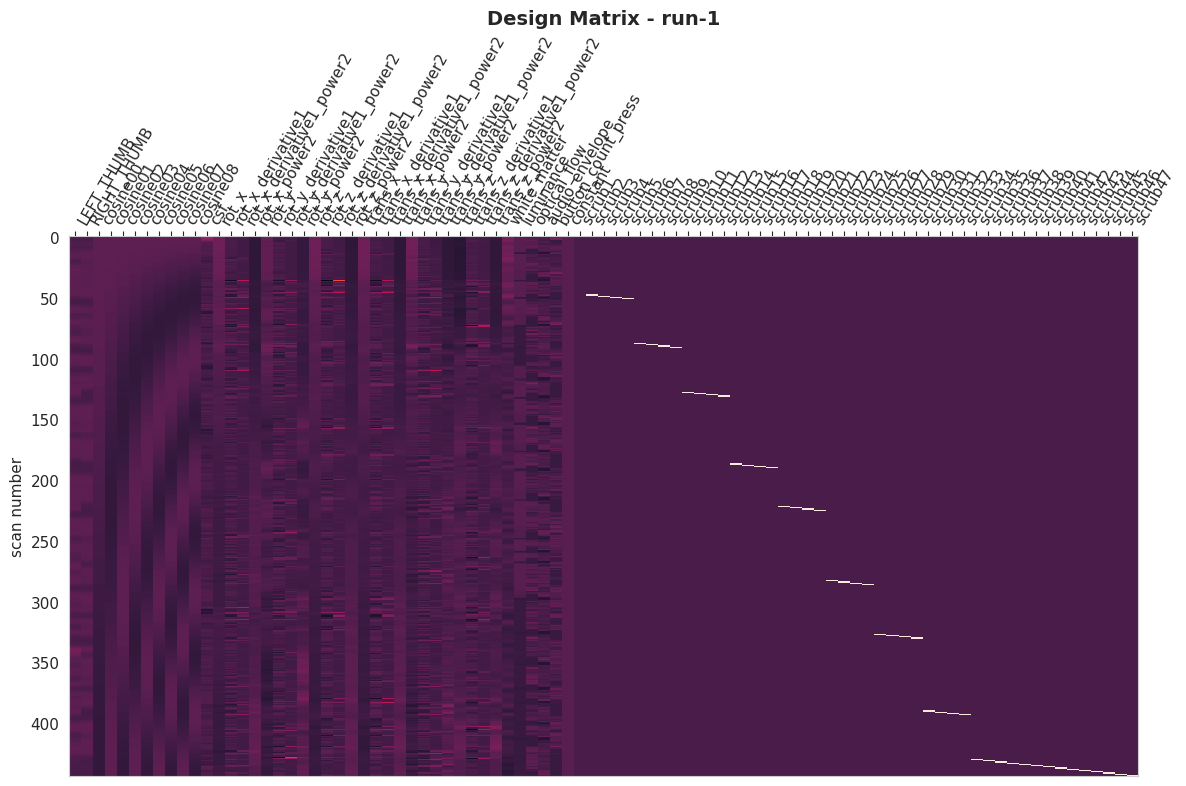

In [10]:
# Step 8: Scrub volumes between repetitions.
def add_scrub_regressors(run_events, design_matrix):
    """Creates a scrub regressor that indicates when a repetition (with available bk2)
    is ongoing or not. If no bk2 is available, the repetition will be ignored and
    scrubbed as 0.

    Parameters
    ----------
    run_events : DataFrame
        The original dataframe created with create_runevents, containing all the events of one run
    design_matrix : DataFrame
        Design matrix as created by Nilearn's make_first_level_design_matrix

    Returns
    -------
    design_matrix : DataFrame
        Same design_matrix as above, with the addition of a scrub confounds.
    """
    reps = []
    # Get repetition segments
    for i in range(len(run_events)):
        if run_events['trial_type'][i] == "gym-retro_game":
            reps.append(run_events.iloc[i,:])

    # Get time vector
    time = np.array(design_matrix.index)

    to_keep = np.zeros(len(time))
    # Generate binary regressor
    for i in range(len(time)):
        for rep in reps:
            if type(rep["stim_file"]) == str and rep["stim_file"] != "Missing file" and type(rep["stim_file"]) != float:
                if time[i] >= rep['onset'] and time[i] <= rep['onset'] + rep['duration']:
                    to_keep[i] = 1.0

    scrub_idx = 1
    for idx, timepoint in enumerate(to_keep):
        if timepoint == 0.0: # If to_keep is zero create a scrub regressor to remove this frame
            scrub_regressor = np.zeros(len(time))
            scrub_regressor[idx] = 1.0
            design_matrix[f'scrub{scrub_idx}'] = scrub_regressor
            scrub_idx += 1
    return design_matrix
design_matrix = add_scrub_regressors(events, design_matrix)
print(f"✓ Added scrub regressors")
print(f"\n📊 Total regressors: {design_matrix.shape[1]}")

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
plot_design_matrix(design_matrix, ax=ax, rescale=True)
ax.set_title(f'Design Matrix - {runs[0]}', fontsize=14, fontweight='bold')
ax.grid(False)  # Deactivate grid
plt.tight_layout()

## 9. Preparing All Runs for Multi-Run GLM

**Multi-run GLM workflow:**

Instead of fitting each run separately and averaging, nilearn's `FirstLevelModel` can fit all runs simultaneously.

**For each run, we:**
1. Load and preprocess BOLD (standardize, detrend)
2. Load and standardize confounds
3. Create hand lateralization events
4. Build design matrix (task + confounds + scrubbing)

**Common brain mask:**
- Compute intersection of all run masks
- Only analyzes voxels valid across ALL runs
- Ensures reliable statistics (no missing data)

This prepares lists of BOLD images and design matrices for simultaneous fitting.

In [11]:
%%time
# Prepare inputs of each run for FirstLevel GLM

from nilearn.image import clean_img
from nilearn.masking import compute_multi_epi_mask
from utils import load_bold, load_brain_mask

print("Preparing data for all runs...\n")

bold_imgs = []
design_matrices = []
confounds_list = []
events_list = []
hand_events_list = []
DESIGN_READY = False
bold_imgs_for_mask = []

for run_idx, run in enumerate(runs):
    print(f"{run}...")
    bold_img = load_bold(SUBJECT, SESSION, run, sourcedata_path)
    bold_imgs_for_mask.append(bold_img) # Keep original for mask computation
    bold_clean = clean_img(
        bold_img,
        standardize=True,
        detrend=True,
        high_pass=None,
        t_r=TR
    )
    bold_imgs.append(bold_clean)

    confounds_df, _ = load_fmriprep_confounds(SUBJECT, SESSION, run)
    events = all_events[run_idx] if EVENTS_LOADED else load_events(SUBJECT, SESSION, run, sourcedata_path)
    events_list.append(events)

    confounds_df = add_button_press_confounds(confounds_df, events, TR)
    lowlevel = load_lowlevel_confounds(SUBJECT, SESSION, run, sourcedata_path)
    confounds_df = add_psychophysics_confounds(confounds_df, lowlevel, TR)

    scaler = StandardScaler()
    confounds_df.loc[:, confounds_df.columns] = scaler.fit_transform(confounds_df)
    confounds_list.append(confounds_df)

    hand_events = create_hand_lateralization_events(events)
    hand_events_list.append(hand_events)

    design_matrix = create_design_matrix(bold_clean, hand_events, confounds_df, TR)
    design_matrix = add_scrub_regressors(events, design_matrix)
    design_matrices.append(design_matrix)

    print(f"  ✓ {bold_clean.shape[-1]} TRs, {len(confounds_df.columns)} confounds, {design_matrix.shape[1]} regressors")

print("\nCreating common mask...")
# Create mask from original images
common_mask = compute_multi_epi_mask(bold_imgs_for_mask, n_jobs=1)
n_voxels_mask = int((common_mask.get_fdata() > 0).sum())
print(f"✓ Common mask: {n_voxels_mask:,} voxels")


DESIGN_READY = len(design_matrices) == len(bold_imgs) and len(bold_imgs) > 0

print(f"\n✓ {len(bold_imgs)} runs prepared")
print(f"✓ Design matrices ready: {DESIGN_READY}")
print(f"✓ Hand event tables: {len(hand_events_list)}")

Preparing data for all runs...

run-1...
  ✓ 444 TRs, 39 confounds, 89 regressors
run-2...
  ✓ 454 TRs, 39 confounds, 97 regressors
run-3...
  ✓ 430 TRs, 39 confounds, 100 regressors
run-4...
  ✓ 471 TRs, 39 confounds, 87 regressors

Creating common mask...
✓ Common mask: 213,443 voxels

✓ 4 runs prepared
✓ Design matrices ready: True
✓ Hand event tables: 4
CPU times: user 2min 25s, sys: 10.1 s, total: 2min 35s
Wall time: 1min


## 10. Fitting the Multi-Run GLM

**Model specification:**

```python
FirstLevelModel(
    t_r=1.49,
    mask_img=common_mask,      # Only brain voxels
    noise_model='ar1',          # AR(1) autocorrelation
    standardize=False,          # Already done
    smoothing_fwhm=5,           # 5mm spatial smoothing
    minimize_memory=True
)
```

**What happens during fitting:**
- For each voxel, estimate β coefficients for all regressors
- Account for temporal autocorrelation (AR1 noise model)
- Apply 5mm spatial smoothing to increase SNR
- Produces session-level β maps

**Runtime:** ~2-3 minutes for 213,443 voxels × 4 runs

In [12]:
%%time
# Fit GLM on all runs

from nilearn.glm.first_level import FirstLevelModel

# Define model
glm = FirstLevelModel(
    t_r=TR,
    mask_img=common_mask,
    noise_model='ar1',        # AR(1) autocorrelation
    standardize=False,        # Already standardized
    smoothing_fwhm=5,         # 5mm FWHM spatial smoothing
    minimize_memory=True
)

# Fit on all runs simultaneously
print("Fitting GLM...")
glm.fit(bold_imgs, design_matrices=design_matrices)

print(f"\n✓ GLM fitted on {len(bold_imgs)} runs")
print(f"  Model: AR(1) noise, SPM HRF")
print(f"  Voxels: {n_voxels_mask:,}")

Fitting GLM...

✓ GLM fitted on 4 runs
  Model: AR(1) noise, SPM HRF
  Voxels: 213,443
CPU times: user 52min 10s, sys: 5.75 s, total: 52min 16s
Wall time: 2min 45s


## 11. Computing the Hand Lateralization Contrast

**Contrast:** LEFT_THUMB - RIGHT_THUMB

**What this does:**
```python
z_map = glm.compute_contrast('LEFT_THUMB - RIGHT_THUMB', output_type='z_score')
```

For each voxel:
- Compute: (β_LEFT_THUMB - β_RIGHT_THUMB) / SE
- Positive z-scores: LEFT_THUMB > RIGHT_THUMB → **right motor cortex** (contralateral)
- Negative z-scores: RIGHT_THUMB > LEFT_THUMB → **left motor cortex** (contralateral)

**Visualization:** Project z-scores onto cortical surface for anatomical interpretation.

✓ Contrast: Hand Lateralization: LEFT_THUMB - RIGHT_THUMB
  Threshold: |Z| > 4.0, cluster > 10 voxels
  (uncorrected for multiple comparisons)

Fetching fsaverage surface...
Projecting volume to surface...


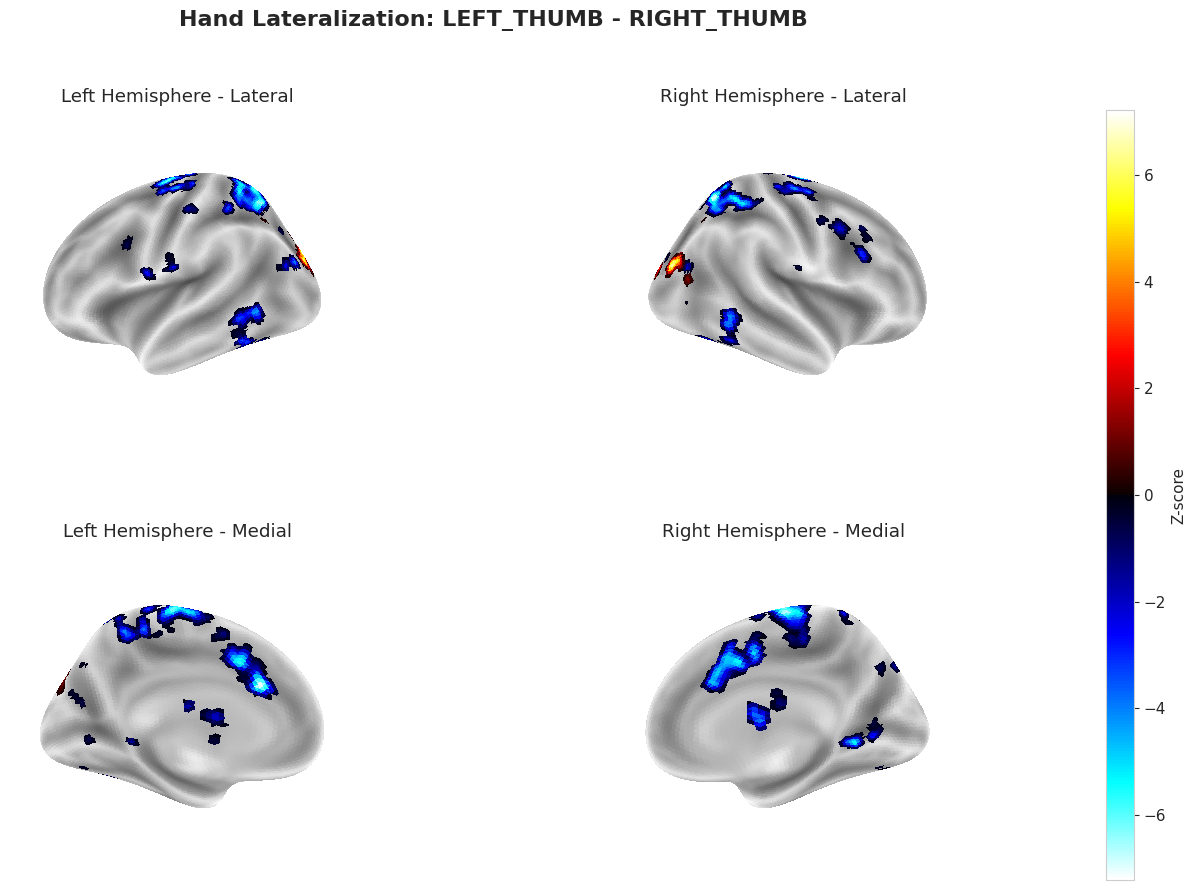


📊 Interpretation:
  Red: LEFT_THUMB > RIGHT_THUMB → Right motor cortex (contralateral)
  Blue: RIGHT_THUMB > LEFT_THUMB → Left motor cortex (contralateral)


In [13]:
# Compute contrast and visualize

from glm_utils import plot_contrast_surfaces

# Compute LEFT_THUMB - RIGHT_THUMB contrast
z_map = glm.compute_contrast('LEFT_THUMB - RIGHT_THUMB', output_type='z_score')

# Plot on surface (using helper function)
fig = plot_contrast_surfaces(
    z_map, 
    contrast_name='Hand Lateralization: LEFT_THUMB - RIGHT_THUMB',
    stat_threshold=4.0,
    cluster_threshold=10
)
plt.show()

print("\n📊 Interpretation:")
print("  Red: LEFT_THUMB > RIGHT_THUMB → Right motor cortex (contralateral)")
print("  Blue: RIGHT_THUMB > LEFT_THUMB → Left motor cortex (contralateral)")

## 12. Multiple Comparison Correction (FWE)

**The multiple comparison problem:**
- Testing 213,443 voxels → high false positive rate
- At p<0.05, expect ~10,672 false positives by chance!

**Cluster-level FWE correction:**
```python
cluster_level_inference(z_map, threshold=3, alpha=0.05)
```

**How it works:**
1. Apply cluster-forming threshold (Z > 3)
2. Find contiguous clusters of supra-threshold voxels
3. Use permutation testing to control family-wise error rate at α=0.05
4. Only keep clusters that survive FWE correction

**Result:** Conservative but reliable — significant clusters have <5% chance of being false positives across the whole brain.

Applying cluster-level FWE correction (alpha=0.05)...

threshold=3 current_default=3.0 old_default=3.0
✓ FWE correction complete
  Cluster-forming threshold: Z > 3.1
  FWE-corrected alpha: 0.05
  Significant voxels: 1,071

Plotting FWE-corrected contrast...
✓ Contrast: Hand Lateralization (FWE-corrected, p<0.05)
  Threshold: |Z| > 0.1, cluster > 0 voxels
  (uncorrected for multiple comparisons)

Fetching fsaverage surface...
Projecting volume to surface...


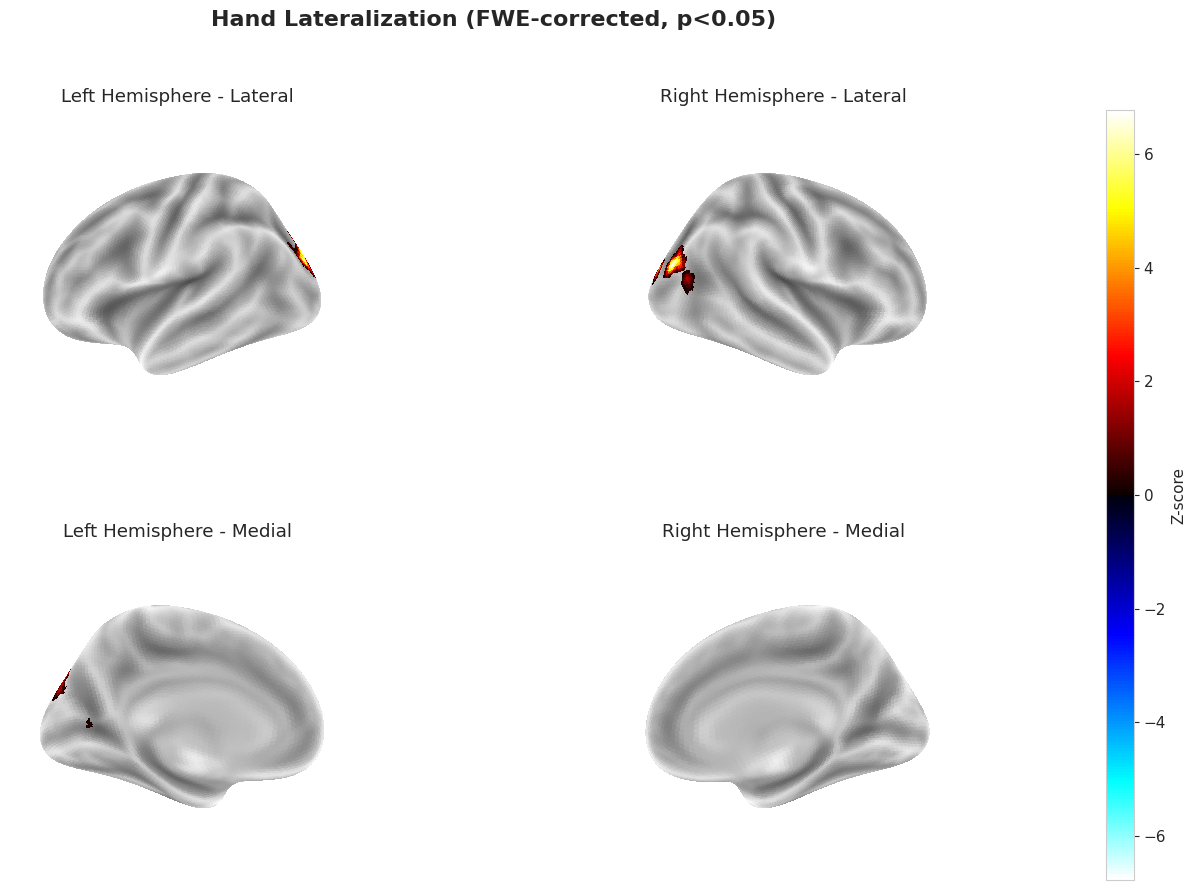


✅ Multiple comparison correction applied!
   Compare this with the uncorrected map above.
   FWE correction is more conservative but controls false positives.
CPU times: user 7.79 s, sys: 9.13 ms, total: 7.79 s
Wall time: 6.96 s


In [14]:
%%time
# Cluster-level FWE correction for multiple comparisons

from nilearn.glm import cluster_level_inference

print("Applying cluster-level FWE correction (alpha=0.05)...\n")

# Perform cluster-level inference with FWE correction
# Returns a Nifti1Image with proportion of true discoveries per voxel
proportion_true_discoveries = cluster_level_inference(
    z_map,
    mask_img=common_mask,
    threshold=3,  # Cluster-forming threshold
    alpha=0.05      # Family-wise error rate
)

print(f"✓ FWE correction complete")
print(f"  Cluster-forming threshold: Z > 3.1")
print(f"  FWE-corrected alpha: 0.05")

# Create FWE-corrected z-map by masking original z-map
# Only keep voxels with proportion > 0 (significant clusters)
from nilearn.image import math_img

z_map_fwe = math_img(
    "img1 * (img2 > 0)",
    img1=z_map,
    img2=proportion_true_discoveries
)

# Count significant voxels
fwe_data = z_map_fwe.get_fdata()
n_sig_voxels = np.sum(np.abs(fwe_data) > 0)

print(f"  Significant voxels: {n_sig_voxels:,}")

# Plot FWE-corrected results
print("\nPlotting FWE-corrected contrast...")
fig = plot_contrast_surfaces(
    z_map_fwe,
    contrast_name='Hand Lateralization (FWE-corrected, p<0.05)',
    stat_threshold=0.1,  # Lower threshold since already FWE-corrected
    cluster_threshold=0
)
plt.show()

print("\n✅ Multiple comparison correction applied!")
print("   Compare this with the uncorrected map above.")
print("   FWE correction is more conservative but controls false positives.")


### Strengths of This Approach

✅ **Event-related design:** Models individual button presses
✅ **Multi-run aggregation:** Robust session-level statistics
✅ **Comprehensive confound control:** Motion, physiology, task, low-level features
✅ **Scrubbing:** Excludes invalid timepoints
✅ **FWE correction:** Proper multiple comparison correction
✅ **Interpretable:** Clear link between behavior and brain

---

### Limitations and Considerations

**1. Sparse Event Coverage**
- Only models button presses (a few events per second)
- Ignores continuous gameplay (visual flow, cognitive planning, value)
- **Alternative:** Encoding models with continuous features (see Section 5)

**2. Hand-Crafted Regressors**
- LEFT_THUMB vs RIGHT_THUMB is our hypothesis
- What if brain codes actions differently? (e.g., spatial vs non-spatial)
- **Alternative:** Data-driven approaches (MVPA, RSA, encoding models)

**3. Session-Level Analysis Only**
- 5 runs, ~25 minutes of data
- Subject-specific activations, not generalizable yet
- **Better:** Multi-session or multi-subject analysis

**4. Hemodynamic Response Assumptions**
- Used canonical SPM HRF (standard shape)
- Real HRF varies across regions and subjects
- **Alternative:** FIR models (finite impulse response) - no HRF assumption

---

### When to Use GLM vs Other Approaches

**GLM is best for:**
- Testing specific hypotheses (e.g., "Does motor cortex code hand laterality?")
- Event-related designs with known trial timing
- Interpreting results in terms of experimental conditions
- Publication in cognitive neuroscience journals

**GLM is limited for:**
- Discovering unexpected brain representations
- Continuous naturalistic stimuli (movies, games)
- Modeling latent variables (value, prediction error, uncertainty)
- Predicting brain activity from complex features

**Complementary approaches:**
- **Encoding models:** Predict BOLD from stimulus/behavior features
- **MVPA (decoding):** Predict behavior from BOLD patterns
- **RSA:** Compare representational geometry
- **ICA/PCA:** Discover data-driven networks

---

### Next Steps

In **Section 5 (Brain Encoding)**, we'll address GLM's limitations by:
1. Using **continuous RL features** (not just button presses)
2. **Predicting BOLD** from learned representations
3. Discovering which brain regions encode **hierarchical game features**
4. Using **data-driven** (not hypothesis-driven) approach

**Key difference:**
- GLM: "Does LEFT_THUMB activate motor cortex?" (test hypothesis)
- Encoding: "What features predict motor cortex activity?" (explore)

Both are valuable! GLM for **interpretation**, encoding for **prediction**.